# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.159502,False,-0.506668
1,-1.659242,False,0.639819
2,1.626842,True,5.158028
3,0.965782,True,6.454791
4,-1.046813,False,0.739615
...,...,...,...
995,-0.912080,False,-0.408059
996,-3.069246,False,1.479008
997,-0.954047,True,6.125326
998,1.524355,True,2.762392


<Axes: xlabel='v0'>

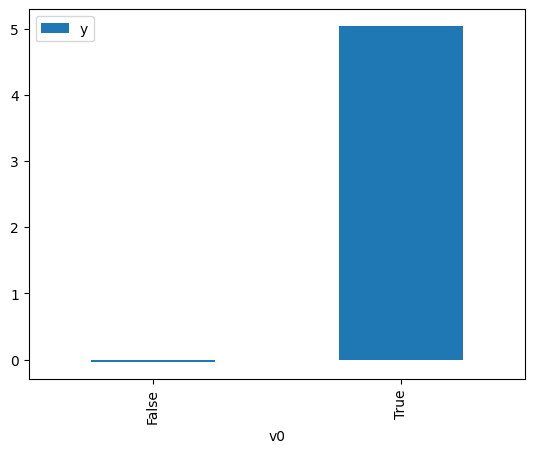

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

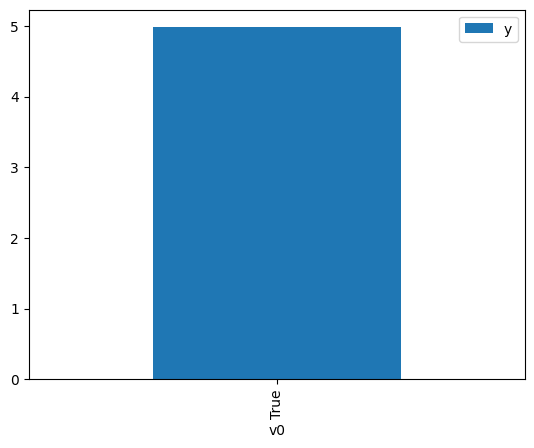

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.251857,False,0.494924,0.902814,1.107648
1,0.598929,False,1.123327,0.233421,4.284106
2,0.446736,False,-2.079906,0.287404,3.479429
3,0.850433,False,-1.801431,0.160628,6.225578
4,-0.852714,False,-0.820435,0.816342,1.224976
...,...,...,...,...,...
995,-0.635193,False,1.762890,0.748391,1.336200
996,-1.454445,False,-1.446179,0.931056,1.074050
997,-0.271202,False,-0.509598,0.602966,1.658467
998,-0.513255,False,-1.504988,0.703674,1.421112


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.960422,True,3.041663,0.155687,6.423128
1,0.016950,True,3.499713,0.528547,1.891980
2,-0.228933,True,5.233415,0.415863,2.404636
3,-1.603075,True,4.877011,0.053277,18.769901
4,-1.977777,True,5.623554,0.027398,36.498661
...,...,...,...,...,...
995,-0.171105,True,6.525288,0.442016,2.262362
996,0.091010,True,6.212970,0.562443,1.777957
997,-0.151497,True,4.515186,0.450965,2.217467
998,-0.919734,True,1.977335,0.165822,6.030559


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              4740.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                        0.00
Time:                        17:53:21   Log-Likelihood:                         -1442.9
No. Observations:                1000   AIC:                                      2890.
Df Residuals:                     998   BIC:                                      2900.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0221      0.030      0.738      0.461      -0.037       0.081
x2             4.9962      0.052     95.237      0.000       4.893       5.099
==============================================================================
Omnibus:                        0.769   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.844
Skew:                           0.028   Prob(JB):                        0.656
Kurtosis:                       2.869   Cond. No.                         1.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""